# 10-minute windows Forecasting with XGBoost Model for Zone 1

The goal is to leverage time series analysis to predict energy consumption in 10-minute windows for the city of Tétouan in Morocco. 

I wrote a medium article about the project, if you're interested into a more in-depth explanation of the code, [check it out](https://towardsdatascience.com/time-series-forecasting-on-power-consumption-273d56768b99)!

# Introduction

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

In [2]:
## Load data using pandas read_csv method
df = pd.read_csv('powerconsumption.csv')

#Setting index to Datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

#Visualizing dataset first 5 records
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [3]:
#Checking % of Null values within dataset
missed = pd.DataFrame()

missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]

missed = missed.sort_values('percent',ascending=False)
print(missed)

                   column  percent
0             Temperature      0.0
1                Humidity      0.0
2               WindSpeed      0.0
3     GeneralDiffuseFlows      0.0
4            DiffuseFlows      0.0
5  PowerConsumption_Zone1      0.0
6  PowerConsumption_Zone2      0.0
7  PowerConsumption_Zone3      0.0


No null values means we can proceed with EDA and Feature Engineering

# Correlation Matrix

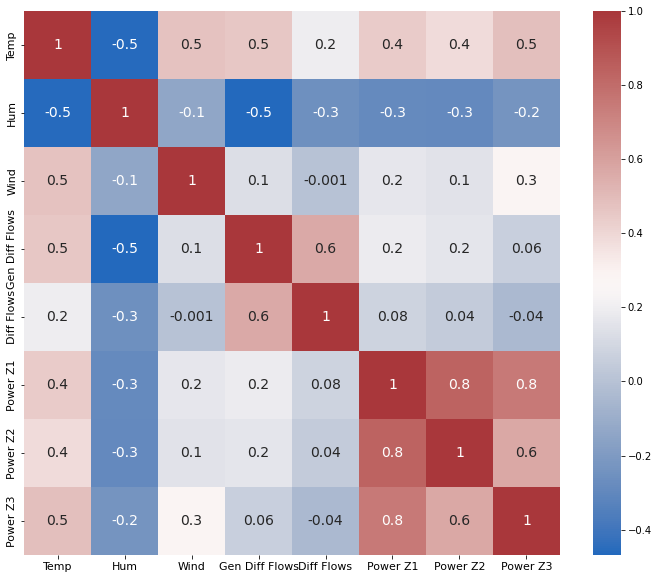

In [4]:
##Correlation Matrix

#Renaming axis labels
axis_labels = ['Temp', 'Hum', 'Wind', 'Gen Diff Flows', 'Diff Flows', 'Power Z1', 'Power Z2', 'Power Z3']

#Setting dimensions and generating heatmap with Seaborn
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap = 'vlag', fmt='.1g', annot_kws={
                'fontsize': 14,
                'fontweight': 'regular',
            }, xticklabels= axis_labels, yticklabels=axis_labels)

#Setting Fontsize for labels
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Generating plot
plt.show()

# Feature Engineering

In [5]:
## Feature Engineering extracts the hour, day of the week, quarter, month etc. from the datetime index

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [6]:
#Calculating 10-day, 15-day and 30-day Simple Moving Average

df['SMA10'] = df['PowerConsumption_Zone1'].rolling(10).mean()
df['SMA15'] = df['PowerConsumption_Zone1'].rolling(15).mean()
df['SMA30'] = df['PowerConsumption_Zone1'].rolling(30).mean()

df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30
Datetime,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1,2017,1,1,52,NaN,NaN,NaN


# EDA

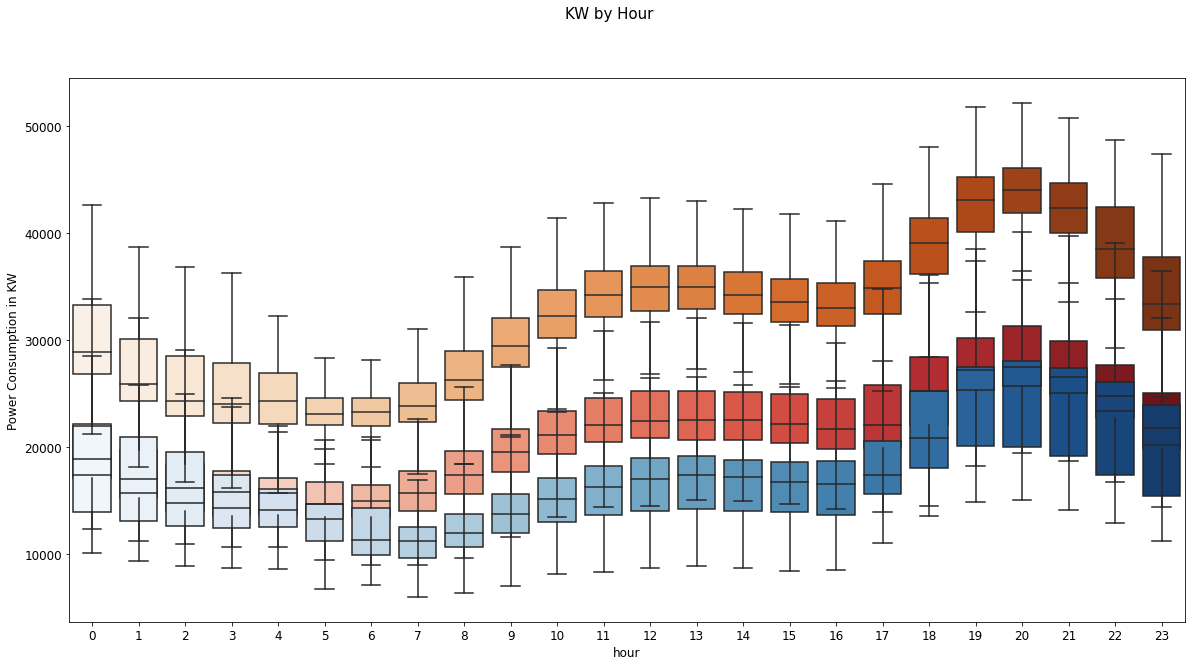

In [7]:

fig, ax = plt.subplots(figsize=(20, 10))

zone1 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone1', palette = 'Oranges', showfliers=False)
zone2 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone2', palette = 'Reds', showfliers=False)
zone3 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone3', palette = 'Blues', showfliers=False)

plt.suptitle('KW by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

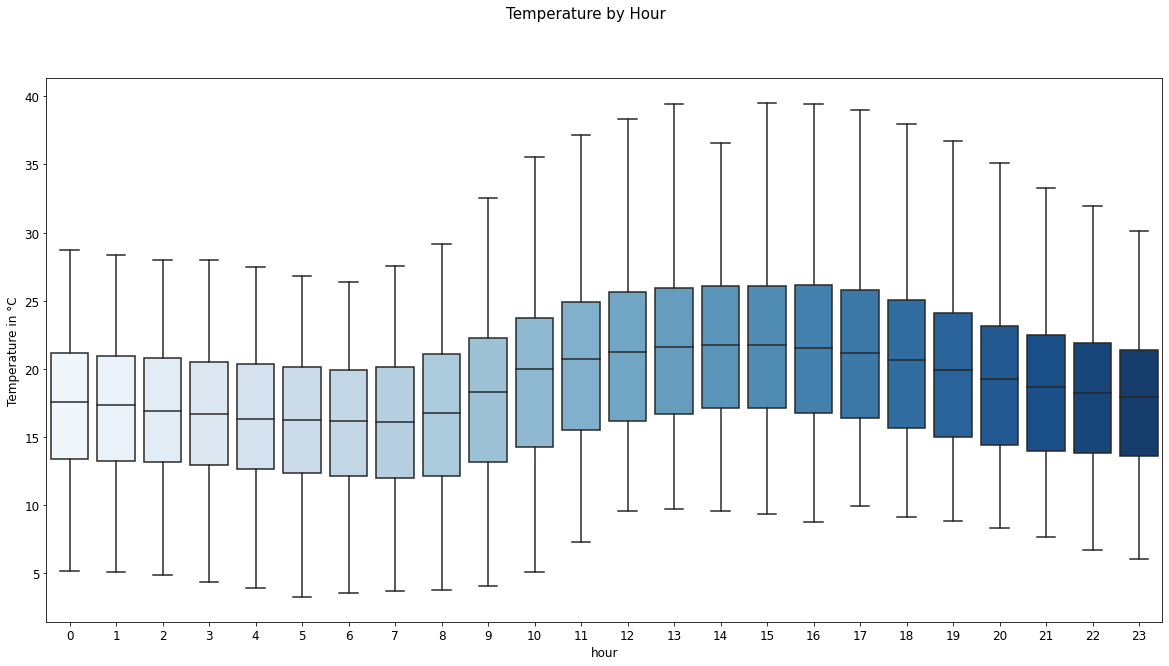

In [8]:

fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Temperature', palette = 'Blues', showfliers=False)

plt.suptitle('Temperature by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Temperature in °C', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

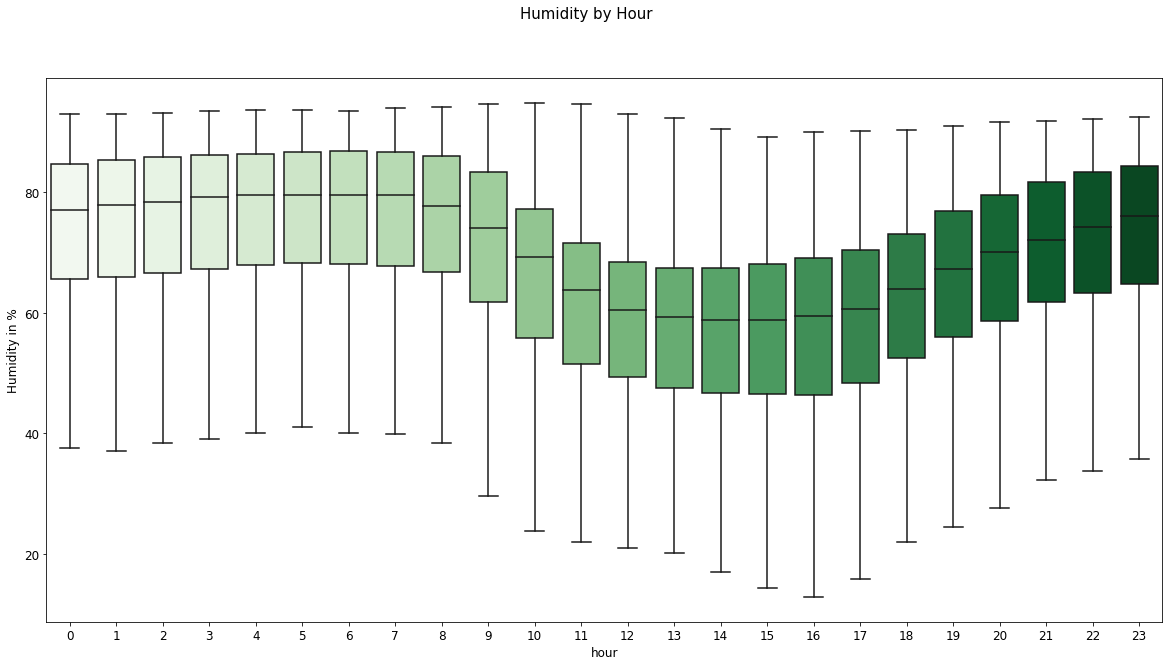

In [9]:

fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Humidity', palette = 'Greens', showfliers=False)

plt.suptitle('Humidity by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Humidity in %', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

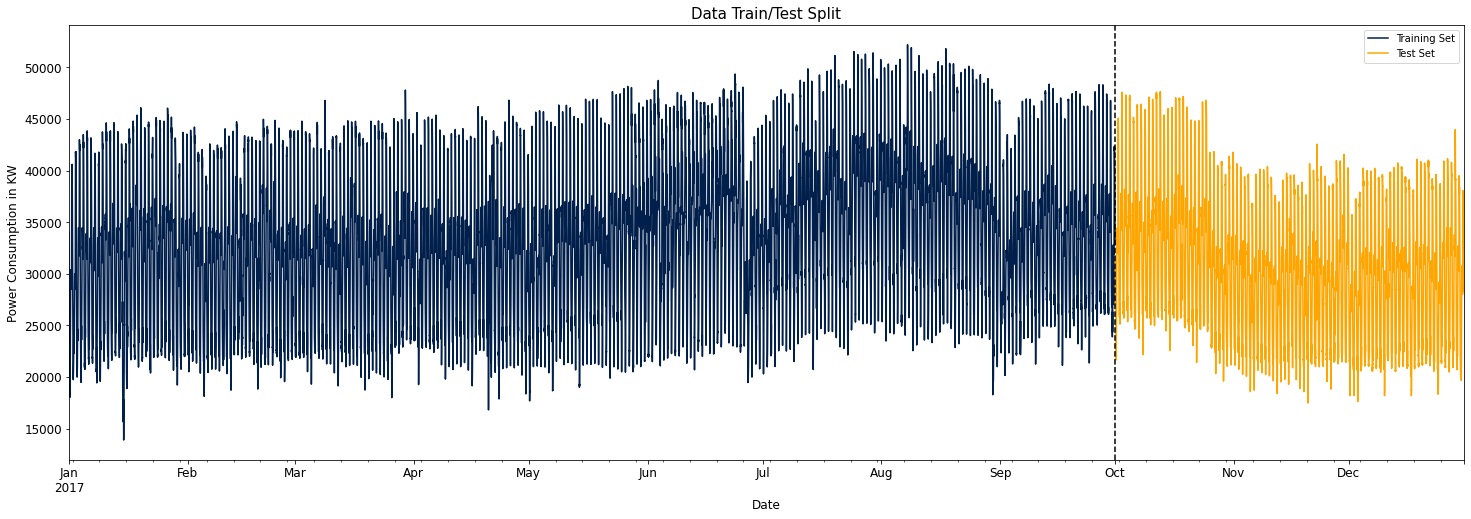

In [10]:
#Train and Test Split
zone_1 = df['PowerConsumption_Zone1']

train = zone_1.loc[zone_1.index < '10-01-2017']
test = zone_1.loc[zone_1.index >= '10-01-2017']

fig, ax = plt.subplots(figsize=(25, 8))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color = "#011f4b")
test.plot(ax=ax, label='Test Set', color="orange")

ax.axvline('10-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.title('Data Train/Test Split', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

# Model Training and Deployment

In [11]:
## Defining input and target variable

#Training data goes from 1st January until 30th of September, input variables are all the columns in the dataset apart from Zone 1,2,3 consumption
X_train = df.loc[:'10-01-2017',['Humidity', 'Temperature', 'WindSpeed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y_train = df.loc[:'10-01-2017', ['PowerConsumption_Zone1']]

#Testing data goes from 1st January until 30th of September, input variables are all the columns in the dataset apart from Zone 1,2,3 consumption
X_test = df.loc['10-01-2017':,['Humidity', 'Temperature', 'WindSpeed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y_test = df.loc['10-01-2017':, ['PowerConsumption_Zone1']]

In [12]:
#Defining model and fitting
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.3, 
                       random_state = 48)

reg.fit(X_train, y_train,         
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:43:51] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23719.59536	validation_1-rmse:21613.57909
[100]	validation_0-rmse:879.67515	validation_1-rmse:1759.45603
[200]	validation_0-rmse:775.53172	validation_1-rmse:1693.56314
[300]	validation_0-rmse:714.23065	validation_1-rmse:1679.04944
[400]	validation_0-rmse:676.79238	validation_1-rmse:1635.98428
[500]	validation_0-rmse:642.64990	validation_1-rmse:1565.16732
[600]	validation_0-rmse:618.19433	validation_1-rmse:1564.60438
[700]	validation_0-rmse:597.37650	validation_1-rmse:1561.23821
[800]	validation_0-rmse:580.51753	validation_1-rmse:1566.84011
[900]	validation_0-rmse:563.88053	validation_1-rmse:1532.57387
[1000]	validation_0-rmse:548.46246	validation_1-rmse:1526.73019
[1100]	validation_0-rmse:536.66015	validation_1-rmse:1500.23187
[1200]	validation_0-rmse:524.73614	validation_1-rmse:1481.39781
[1300]	validation_0-rmse:513.88006	validation_1-rmse:1552.

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=48, reg_alpha=0, ...)

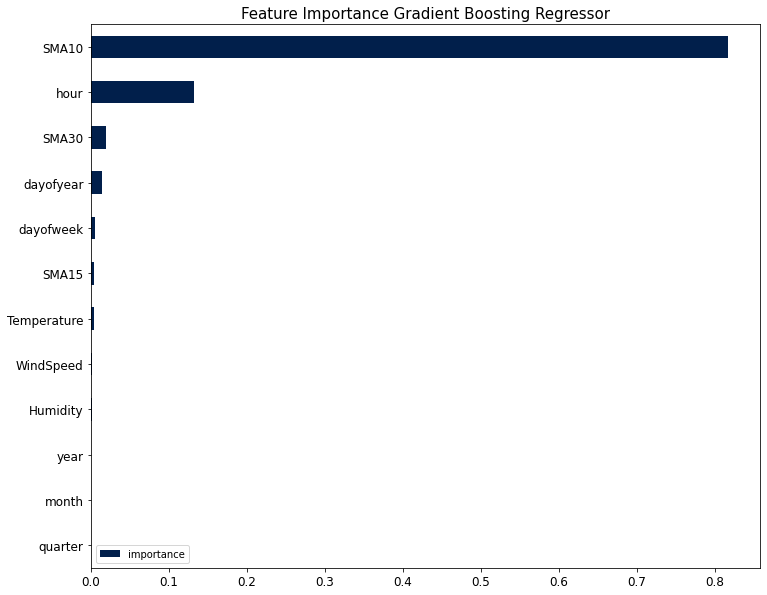

In [13]:
##Assessing Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=X_train.columns,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance', color = "#011f4b", figsize=(12,10))
plt.title('Feature Importance Gradient Boosting Regressor', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

In [14]:
##Merging predictions with original dataset
y_test = pd.DataFrame(y_test)
y_test['prediction'] = reg.predict(X_test)
df = df.merge(y_test[['prediction']], how='left', left_index=True, right_index=True)

df.tail()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30,prediction
Datetime,,,,,,,,,,,,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,5,4,12,2017,364,30,52,33634.068441,34403.447401,35936.121673,31630.021484
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,5,4,12,2017,364,30,52,33217.946768,33990.570342,35683.041825,32094.777344
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,5,4,12,2017,364,30,52,32730.038022,33540.380227,35402.382763,31952.400391
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23,5,4,12,2017,364,30,52,32133.840303,33082.078579,35107.528517,31200.755859
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23,5,4,12,2017,364,30,52,31495.057033,32597.820025,34796.451204,30431.855469


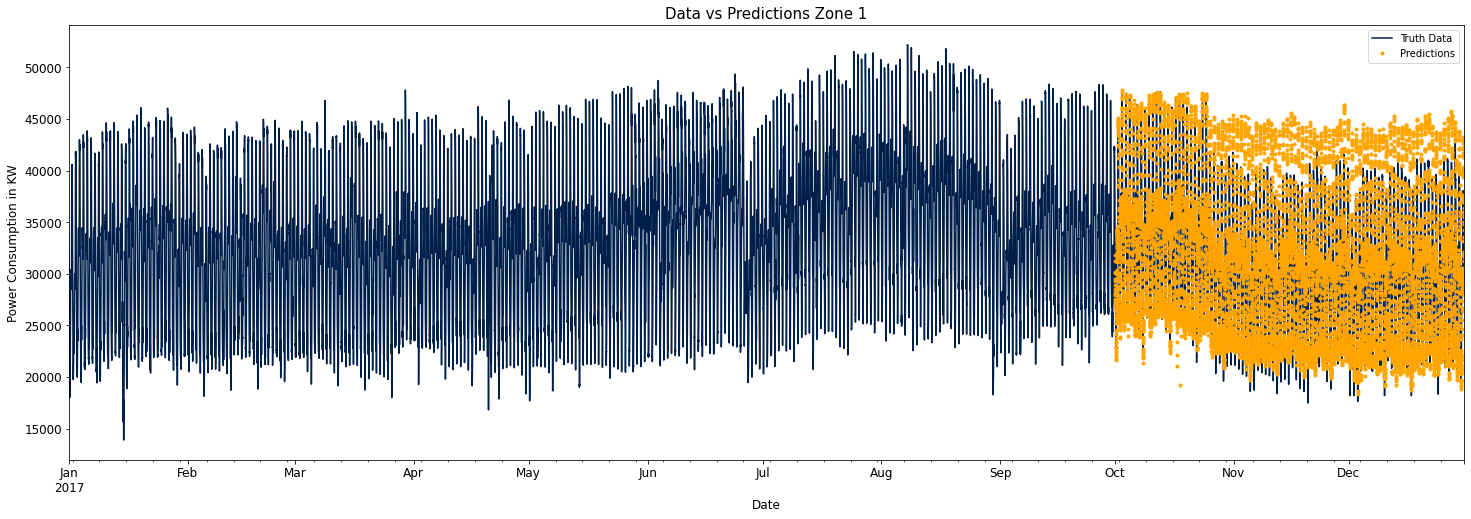

In [15]:
##Printing predictions on chart to visually assess accuracy
ax = df[['PowerConsumption_Zone1']].plot(figsize=(25, 8), color = "#011f4b")
y_test['prediction'].plot(ax=ax, style='.', color = "orange")
plt.legend(['Truth Data', 'Predictions'])

plt.title('Data vs Predictions Zone 1', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

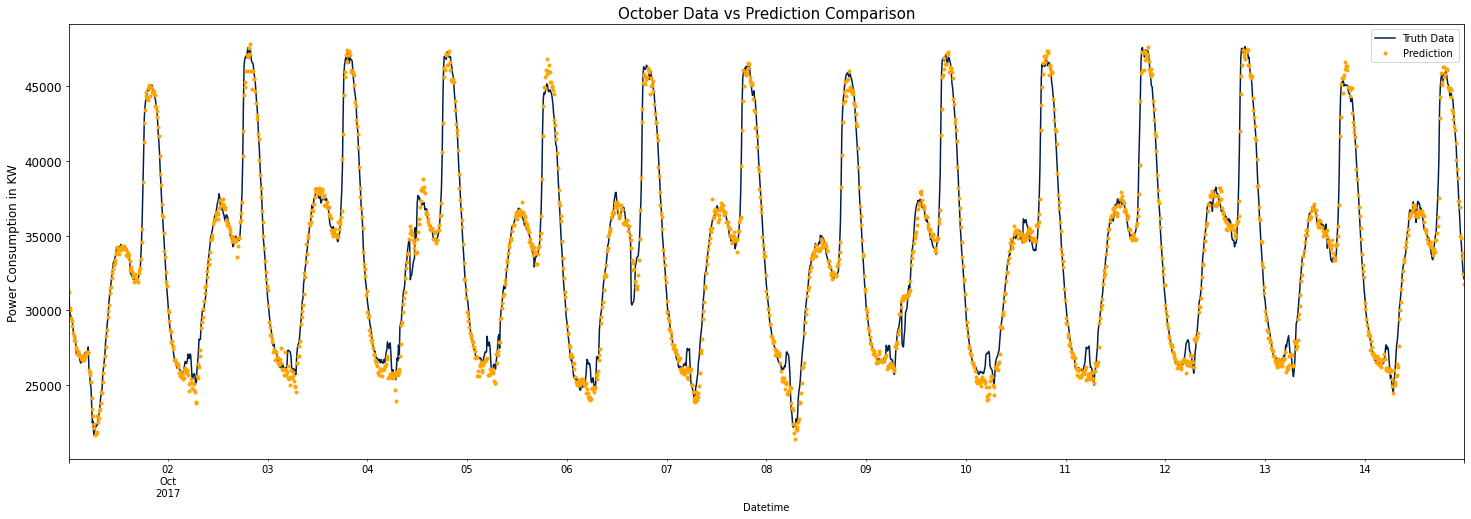

In [16]:
##Printing October predictions on chart to visually assess accuracy
ax = df.loc[(df.index > '10-01-2017') & (df.index < '10-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='October Data vs Prediction Comparison', color = "#011f4b")
df.loc[(df.index > '10-01-2017') & (df.index < '10-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('October Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

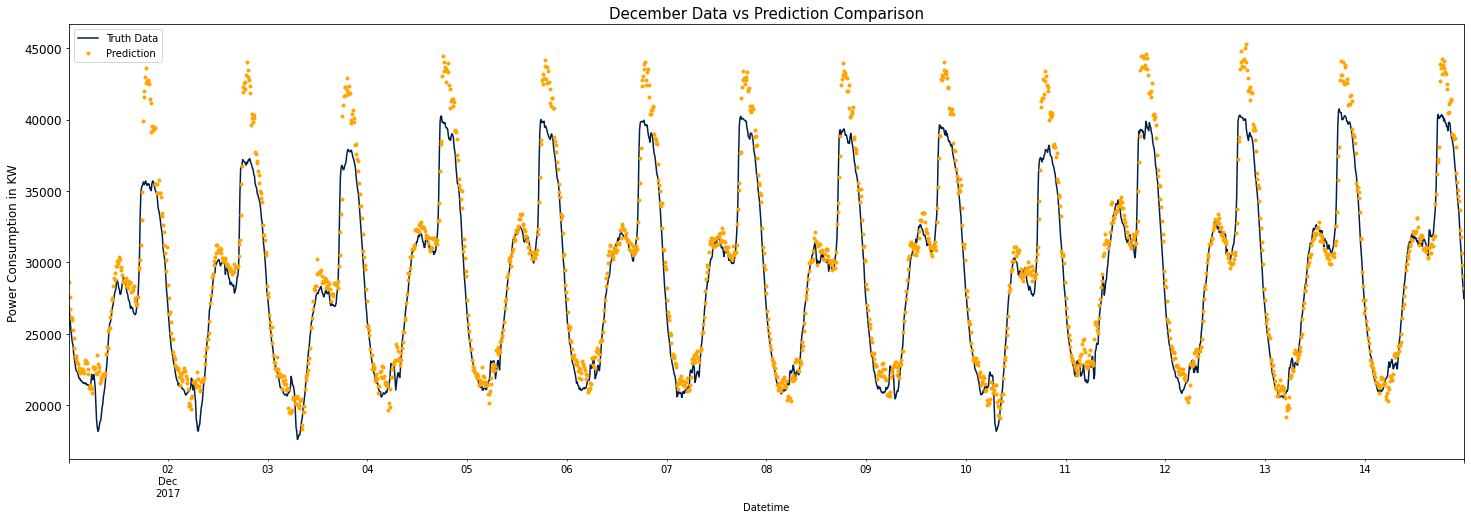

In [17]:
##Printing December predictions on chart to visually assess accuracy
ax = df.loc[(df.index > '12-01-2017') & (df.index < '12-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='December Data vs Prediction Comparison', color = "#011f4b")
df.loc[(df.index > '12-01-2017') & (df.index < '12-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('December Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

# Accuracy Assessment

In [18]:
##Function to calculate regression metrics, evaluating accuracy
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    mape = (1- metrics.mean_absolute_percentage_error(y_true, y_pred))


    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,4))

In [19]:
#Apply function and print results
regression_results(y_test['PowerConsumption_Zone1'], y_test['prediction'])

explained_variance:  0.9497
mean_squared_log_error:  0.0021
r2:  0.942
MAE:  1052.1826
MSE:  2415661.9171
RMSE:  1554.24
MAPE:  0.9659


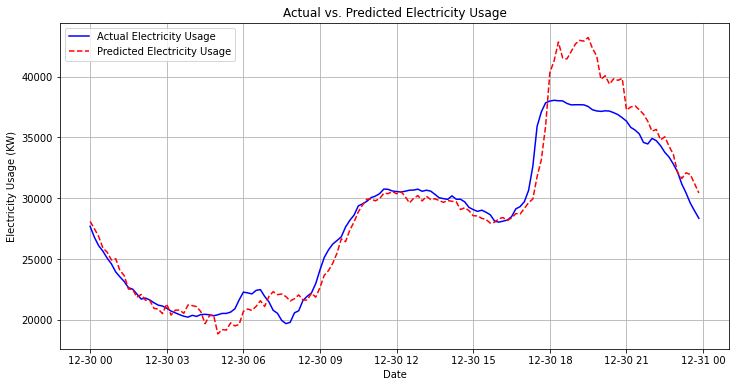

                     Predicted_Electricity_Usage
Datetime                                        
2017-12-30 23:10:00                 31630.021484
2017-12-30 23:20:00                 32094.777344
2017-12-30 23:30:00                 31952.400391
2017-12-30 23:40:00                 31200.755859
2017-12-30 23:50:00                 30431.855469


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def predict_and_plot_electricity_usage(model, df, start_date, end_date):
    """
    Predict electricity usage for a specific month and plot against actual values.

    Args:
    - model: Trained machine learning model (e.g., XGBoost regressor)
    - df: DataFrame containing features used for prediction
    - start_date: Start date of the month (format: 'YYYY-MM-DD')
    - end_date: End date of the month (format: 'YYYY-MM-DD')

    Returns:
    - predicted_df: DataFrame containing the predicted electricity usage for the specified month
    """

    # Filter the DataFrame to include data for the specified month
    month_data = df.loc[(df.index >= start_date) & (df.index <= end_date)]

    if month_data.empty:
        raise ValueError("No data available for the specified month.")

    # Extract features for prediction
    features = month_data[['Humidity', 'Temperature', 'WindSpeed', 'dayofyear', 
                           'hour', 'dayofweek', 'quarter', 'month', 'year',
                           'SMA10', 'SMA30', 'SMA15']]

    if features.empty:
        raise ValueError("No features available for the specified month.")

    # Make predictions using the trained model
    predictions = model.predict(features)

    if len(predictions) == 0:
        raise ValueError("Failed to make predictions for the specified month.")

    # Create a DataFrame to hold the predictions
    predicted_df = pd.DataFrame(index=month_data.index)
    predicted_df['Predicted_Electricity_Usage'] = predictions

    # Plot actual vs. predicted electricity usage
    plt.figure(figsize=(12, 6))
    plt.plot(month_data.index, month_data['PowerConsumption_Zone1'], label='Actual Electricity Usage', color='blue')
    plt.plot(predicted_df.index, predicted_df['Predicted_Electricity_Usage'], label='Predicted Electricity Usage', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Electricity Usage (KW)')
    plt.title('Actual vs. Predicted Electricity Usage')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    return predicted_df

# Example usage:
start_date = '2017-12-30'  # Start date of the month to predict
end_date = '2018-10-2'    # End date of the month to predict

try:
    predicted_usage = predict_and_plot_electricity_usage(reg, df, start_date, end_date)
    
    print(predicted_usage.tail())
except ValueError as e:
    print("Error:", e)
    



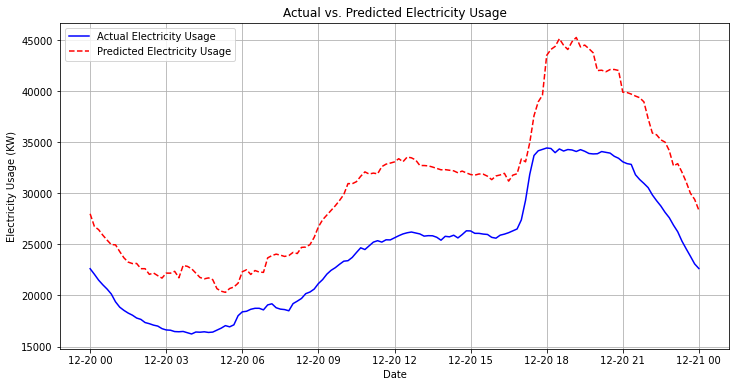

                     Predicted_Electricity_Usage
Datetime                                        
2017-12-20 00:00:00                 27997.517578
2017-12-20 00:10:00                 26762.082031
2017-12-20 00:20:00                 26446.658203
2017-12-20 00:30:00                 25901.939453
2017-12-20 00:40:00                 25423.744141
...                                          ...
2017-12-20 23:20:00                 32074.966797
2017-12-20 23:30:00                 31120.074219
2017-12-20 23:40:00                 30010.232422
2017-12-20 23:50:00                 29409.746094
2017-12-21 00:00:00                 28347.191406

[145 rows x 1 columns]


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def predict_and_plot_electricity_usage(model, df, start_date, end_date):
    """
    Predict electricity usage for a specific month and plot against actual values.

    Args:
    - model: Trained machine learning model (e.g., XGBoost regressor)
    - df: DataFrame containing features used for prediction
    - start_date: Start date of the month (format: 'YYYY-MM-DD')
    - end_date: End date of the month (format: 'YYYY-MM-DD')

    Returns:
    - predicted_df: DataFrame containing the predicted electricity usage for the specified month
    """

    # Filter the DataFrame to include data for the specified month
    month_data = df.loc[(df.index >= start_date) & (df.index <= end_date)]

    if month_data.empty:
        raise ValueError("No data available for the specified month.")

    # Extract features for prediction
    features = month_data[['Humidity', 'Temperature', 'WindSpeed', 'dayofyear', 
                           'hour', 'dayofweek', 'quarter', 'month', 'year',
                           'SMA10', 'SMA30', 'SMA15']]

    if features.empty:
        raise ValueError("No features available for the specified month.")

    # Make predictions using the trained model
    predictions = model.predict(features)

    if len(predictions) == 0:
        raise ValueError("Failed to make predictions for the specified month.")

    # Create a DataFrame to hold the predictions
    predicted_df = pd.DataFrame(index=month_data.index)
    predicted_df['Predicted_Electricity_Usage'] = predictions

    # Plot actual vs. predicted electricity usage
    plt.figure(figsize=(12, 6))
    plt.plot(month_data.index, month_data['PowerConsumption_Zone2'], label='Actual Electricity Usage', color='blue')
    plt.plot(predicted_df.index, predicted_df['Predicted_Electricity_Usage'], label='Predicted Electricity Usage', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Electricity Usage (KW)')
    plt.title('Actual vs. Predicted Electricity Usage')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_df

# Example usage:
start_date = '2017-12-20'  # Start date of the month to predict
end_date = '2017-12-21'    # End date of the month to predict

try:
    predicted_usage = predict_and_plot_electricity_usage(reg, df, start_date, end_date)
    print(predicted_usage)
except ValueError as e:
    print("Error:", e)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def predict_and_plot_electricity_usage(model, df, start_date, end_date):
    """
    Predict electricity usage for a specific month and plot against actual values.

    Args:
    - model: Trained machine learning model (e.g., XGBoost regressor)
    - df: DataFrame containing features used for prediction
    - start_date: Start date of the month (format: 'YYYY-MM-DD')
    - end_date: End date of the month (format: 'YYYY-MM-DD')

    Returns:
    - predicted_df: DataFrame containing the predicted electricity usage for the specified month
    """

    # Filter the DataFrame to include data for the specified month
    month_data = df.loc[(df.index >= start_date) & (df.index <= end_date)]

    if month_data.empty:
        raise ValueError("No data available for the specified month.")

    # Extract features for prediction
    features = month_data[['Humidity', 'Temperature', 'WindSpeed', 'dayofyear', 
                           'hour', 'dayofweek', 'quarter', 'month', 'year',
                           'SMA10', 'SMA30', 'SMA15']]

    if features.empty:
        raise ValueError("No features available for the specified month.")

    # Make predictions using the trained model
    predictions = model.predict(features)

    if len(predictions) == 0:
        raise ValueError("Failed to make predictions for the specified month.")

    # Create a DataFrame to hold the predictions
    predicted_df = pd.DataFrame(index=month_data.index)
    predicted_df['Predicted_Electricity_Usage'] = predictions

    # Plot actual vs. predicted electricity usage
    plt.figure(figsize=(12, 6))
    plt.plot(month_data.index, month_data['PowerConsumption_Zone3'], label='Actual Electricity Usage', color='blue')
    plt.plot(predicted_df.index, predicted_df['Predicted_Electricity_Usage'], label='Predicted Electricity Usage', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Electricity Usage (KW)')
    plt.title('Actual vs. Predicted Electricity Usage')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_df

# Example usage:
start_date = '2017-01-20'  # Start date of the month to predict
end_date = '2017-12-21'    # End date of the month to predict

try:
    predicted_usage = predict_and_plot_electricity_usage(reg, df, start_date, end_date)
    print(predicted_usage)
except ValueError as e:
    print("Error:", e)


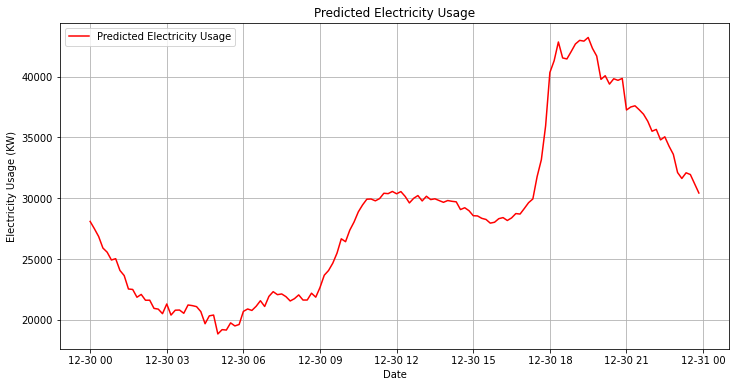

                     Predicted_Electricity_Usage
Datetime                                        
2017-12-30 00:00:00                 28094.748047
2017-12-30 00:10:00                 27494.074219
2017-12-30 00:20:00                 26853.736328
2017-12-30 00:30:00                 25906.605469
2017-12-30 00:40:00                 25562.687500
...                                          ...
2017-12-30 23:10:00                 31630.021484
2017-12-30 23:20:00                 32094.777344
2017-12-30 23:30:00                 31952.400391
2017-12-30 23:40:00                 31200.755859
2017-12-30 23:50:00                 30431.855469

[144 rows x 1 columns]


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def predict_and_plot_electricity_usage(model, df, start_date, end_date):
    """
    Predict electricity usage for a specific month and plot the predicted values.

    Args:
    - model: Trained machine learning model (e.g., XGBoost regressor)
    - df: DataFrame containing features used for prediction
    - start_date: Start date of the month (format: 'YYYY-MM-DD')
    - end_date: End date of the month (format: 'YYYY-MM-DD')

    Returns:
    - predicted_df: DataFrame containing the predicted electricity usage for the specified month
    """

    # Extract features for prediction
    features = df.loc[(df.index >= start_date) & (df.index <= end_date)][['Humidity', 'Temperature', 'WindSpeed', 'dayofyear', 
                                'hour', 'dayofweek', 'quarter', 'month', 'year',
                                'SMA10', 'SMA30', 'SMA15']]

    # Make predictions using the trained model
    predictions = model.predict(features)

    # Create a DataFrame to hold the predictions
    predicted_df = pd.DataFrame(index=features.index)
    predicted_df['Predicted_Electricity_Usage'] = predictions

    # Plot predicted electricity usage
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df.index, predicted_df['Predicted_Electricity_Usage'], label='Predicted Electricity Usage', color='red', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Electricity Usage (KW)')
    plt.title('Predicted Electricity Usage')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_df

# Example usage:
start_date = '2017-12-30'  # Start date of the month to predict
end_date = '2019-04-30'    # End date of the month to predict

try:
    predicted_usage = predict_and_plot_electricity_usage(reg, df, start_date, end_date)
    print(predicted_usage)
except ValueError as e:
    print("Error:", e)


## References
[1] Salam, A., & El Hibaoui, A. (2018, December). Comparison of Machine Learning Algorithms for the Power Consumption Prediction:-Case Study of Tetouan city–. In 2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1–5). IEEE.

[2] robikscube. (2022, July 5). Time Series Forecasting with Machine Learning [YT]. Retrieved September 29, 2022, from Kaggle.com website: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt